In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('StudentsPerformance_with_performance.csv')

# Display the first few rows of the dataset
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,performance
0,0,1,1,1,1,72,72,74,Medium
1,0,2,4,1,0,69,90,88,High
2,0,1,3,1,1,90,95,93,High
3,1,0,0,0,1,47,57,44,Low
4,1,2,4,1,1,76,78,75,High


In [2]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
le = LabelEncoder()
data = df.copy

# Apply label encoding to the 'performance' column
data['performance_encoded'] = le.fit_transform(data['performance'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Show the first few rows of the updated dataset and the label mapping
data.head(), label_mapping


(   gender  race/ethnicity  parental level of education  lunch  \
 0       0               1                            1      1   
 1       0               2                            4      1   
 2       0               1                            3      1   
 3       1               0                            0      0   
 4       1               2                            4      1   
 
    test preparation course  math score  reading score  writing score  \
 0                        1          72             72             74   
 1                        0          69             90             88   
 2                        1          90             95             93   
 3                        1          47             57             44   
 4                        1          76             78             75   
 
   performance  performance_encoded  
 0      Medium                    2  
 1        High                    0  
 2        High                    0  
 3        

In [3]:
# Drop the 'performance' column
droppedvariable = data.drop('performance', axis=1)

# Display the first few rows of the updated dataset
droppedvariable.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,performance_encoded
0,0,1,1,1,1,72,72,74,2
1,0,2,4,1,0,69,90,88,0
2,0,1,3,1,1,90,95,93,0
3,1,0,0,0,1,47,57,44,1
4,1,2,4,1,1,76,78,75,0


KeyError: 0

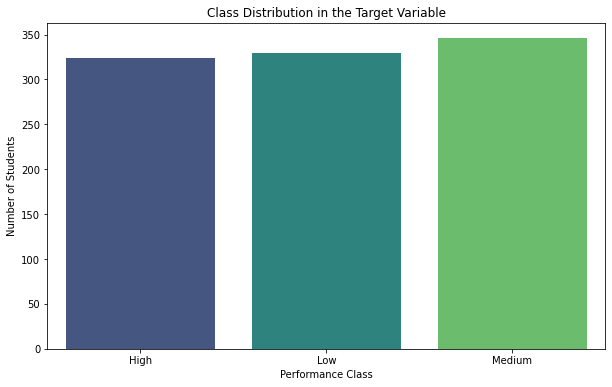

In [5]:
# Correctly map encoded labels back to their original labels for display purposes
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
class_labels_corrected = [inverse_label_mapping[key] for key in class_counts.index]

# Plot the class distribution using the corrected labels
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels_corrected, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in the Target Variable')
plt.xlabel('Performance Class')
plt.ylabel('Number of Students')
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into features and target variable
X = droppedvariable.drop('performance_encoded', axis=1)
y = droppedvariable['performance_encoded']

# Split the data into training and test sets (80% train, 20% test)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

Xtrain.shape, Xtest.shape


((800, 8), (200, 8))

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import time

# Initialize the models
logreg = LogisticRegression(max_iter=5000, random_state=42)
svm = SVC(probability=True, random_state=42)
dtree = DecisionTreeClassifier(random_state=42)

models = [('Logistic Regression', logreg), ('SVM', svm), ('Decision Tree', dtree)]
cross_val_scores = {}
execution_times = {}

# Train the models and perform k-fold cross-validation
for name, model in models:
    start_time = time.time()
    scores = cross_val_score(model, Xtrain, ytrain, cv=5, scoring='accuracy')
    end_time = time.time()
    
    cross_val_scores[name] = scores.mean()
    execution_times[name] = end_time - start_time

cross_val_scores, execution_times


({'Logistic Regression': 0.9925,
  'SVM': 0.9824999999999999,
  'Decision Tree': 0.94625},
 {'Logistic Regression': 1.758399248123169,
  'SVM': 0.16978740692138672,
  'Decision Tree': 0.02859663963317871})

In [8]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix

# Dictionaries to store performance metrics
accuracies = {}
recalls = {}
roc_aucs = {}

# Train the models on the training data and evaluate on the test data
for name, model in models:
    model.fit(Xtrain, ytrain)
    y_pred = model.predict(Xtest)
    
    # Compute performance metrics
    accuracies[name] = accuracy_score(ytest, y_pred)
    recalls[name] = recall_score(ytest, y_pred, average='macro')
    
    # For ROC AUC, we need probability estimates of the positive class
    y_prob = model.predict_proba(Xtest) 
    roc_aucs[name] = roc_auc_score(ytest, y_prob, multi_class='ovr', average='macro')

accuracies, recalls, roc_aucs


({'Logistic Regression': 0.99, 'SVM': 0.96, 'Decision Tree': 0.93},
 {'Logistic Regression': 0.9894153225806451,
  'SVM': 0.9611486486486487,
  'Decision Tree': 0.9288905841325197},
 {'Logistic Regression': 0.9998837854011403,
  'SVM': 0.9998837854011403,
  'Decision Tree': 0.9471387317609783})

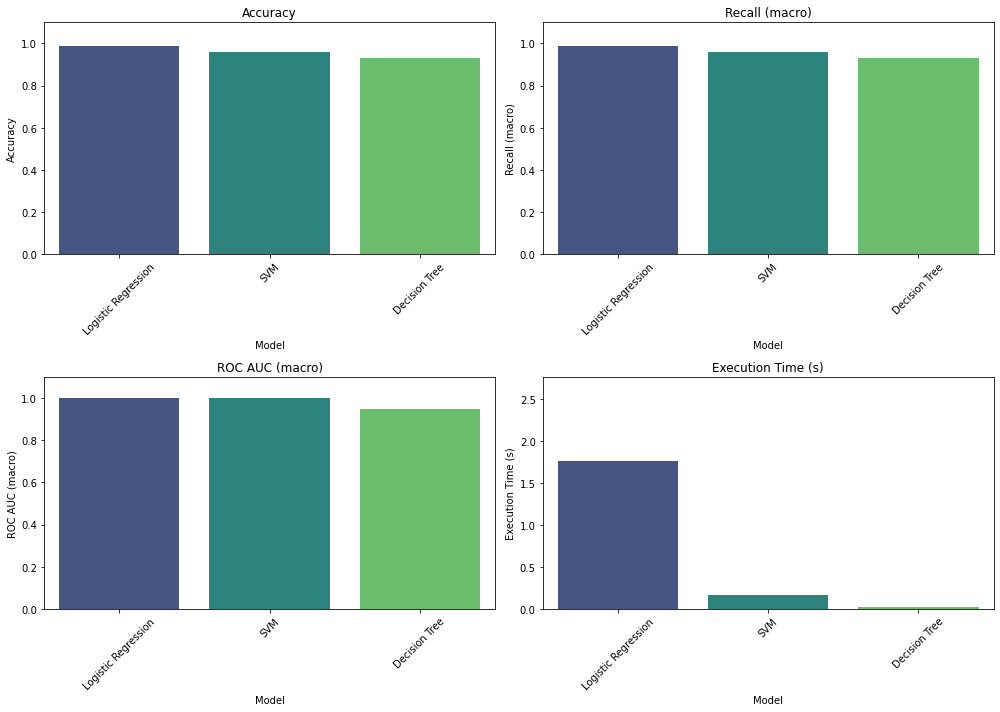

,Model,Accuracy,Recall (macro),ROC AUC (macro),Execution Time (s)
0,Logistic Regression,0.99,0.989415,0.999884,1.758399
1,SVM,0.96,0.961149,0.999884,0.169787
2,Decision Tree,0.93,0.928891,0.947139,0.028597


In [9]:
# Convert the performance metrics into a DataFrame for visualization
performance_df = pd.DataFrame({
    'Model': list(accuracies.keys()),
    'Accuracy': list(accuracies.values()),
    'Recall (macro)': list(recalls.values()),
    'ROC AUC (macro)': list(roc_aucs.values()),
    'Execution Time (s)': list(execution_times.values())
})

# Plot the performance metrics in a bar plot
plt.figure(figsize=(14, 10))
metrics = ['Accuracy', 'Recall (macro)', 'ROC AUC (macro)', 'Execution Time (s)']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(x='Model', y=metric, data=performance_df, palette='viridis')
    plt.title(metric)
    plt.ylim(0, 1.1) if metric != 'Execution Time (s)' else plt.ylim(0, max(execution_times.values()) + 1)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

# Return the performance table
performance_df


NameError: name 'X_train' is not defined